In [1]:
import os
import json
import pandas as pd
import numpy as np
import sklearn
from sklearn.cluster import KMeans
from sklearn.decomposition import KernelPCA, PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

plt.rcParams['figure.figsize'] = [15, 9]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower


In [2]:
def load_investor_summary():
    files = list(os.walk("../scrapy_projects/etoro/etoro/"))[0][2]
    etoro_sum_paths = [f for f in files if f.startswith("investor_dashboard")]
    with open(f"../scrapy_projects/etoro/etoro/{ sorted(etoro_sum_paths)[-1]}","r") as f:
        etoro_investor_sum = json.load(f)
        
    return etoro_investor_sum


def load_investor_portfolio():
    files = list(os.walk("../scrapy_projects/etoro/etoro/"))[0][2]
    etoro_investor_paths = [f for f in files if f.startswith("investor_portfolio")]
    etoro_investors = []
    for path in etoro_investor_paths:
        with open(f"../scrapy_projects/etoro/etoro/{path}","r") as f:
            _ = json.load(f)
            etoro_investors.extend(_)


    investor_portfolio = []
    for investor in etoro_investors:
        for item in investor["items"]:
            row = {"investor_name":investor["investor_name"],
                        "date":investor["datetime"],
                        "company":item["company_ticker"],
                        "type":item["type"],
                        "invested":item["invested"].replace("<","").replace("%","")}
            investor_portfolio.append(row)
    return investor_portfolio



def load_marketbeat():
    files = list(os.walk("../scrapy_projects/marketbeat/marketbeat/"))[0][2]
    dashboard_files = [f for f in files if f.startswith("marketbeat_dashboard")]
    dfs = []
    
    for file_path in dashboard_files:
        file_date = file_path.split("_")[-1].split(".")[0]
        with open(f"../scrapy_projects/marketbeat/marketbeat/{file_path}",'r') as f:
            this_data = json.load(f)
            df = pd.DataFrame(this_data)
            df["date"] = file_date
            df["date"] = pd.to_datetime(df["date"],format='%d-%m-%y')
            df["overall_rank"] = df["overall_rank"].apply(lambda x: x.replace("out of 5 stars","") if x else -1)
            for col in df.columns:
                if col.endswith("rank"):
                    df[col] = df[col].astype(np.float64)
            dfs.append(df)
            
    return pd.concat(dfs)

def load_marketbeat_target():
    dfs = []
    with open(f"../scrapy_projects/marketbeat/marketbeat/marketbeat_price_target.json",'r') as f:
         _ = json.load(f)
    for stock in _:
        if len(stock["history"]) > 0:
            df = pd.DataFrame(stock["history"])
            df["symbol"] = stock["stock"]
            df["date"] = pd.to_datetime(df["Date"])
            df = df.drop(["Date","Unnamed: 6"],axis=1,inplace=False)
            dfs.append(df)
    return pd.concat(dfs)

def load_marketwatch():
    files = list(os.walk("../scrapy_projects/marketwatch/marketwatch/"))[0][2]
    files = [f for f in files if f.startswith("marketwatch")]
    
    dfs = []
    for file_path in files:
            file_date = file_path.split("_")[-1].split(".")[0]
            with open(f"../scrapy_projects/marketwatch/marketwatch/{file_path}",'r') as f:
                this_data = json.load(f)
                rows = []
                for stock in this_data:
                    row = {"date": file_date}
                    row.update({"symbol":stock["symbol"]})
                    row.update({k:v for k,v in stock["snapshot"].items()})
                    row.update({k:v for k,v in stock["price_target"].items()})
                    rows.append(row)
            df = pd.DataFrame(rows)
            df["date"] = pd.to_datetime(df["date"],format='%d-%m-%y')
            dfs.append(df)
    marketwatch_df = pd.concat(dfs)
    
    number_cols = ["High", "Median", "Low", "Average", "Current Price"]
    for col in number_cols:
        marketwatch_df[col] = marketwatch_df[col].apply(lambda x: float(x.replace("$","").replace(",","").replace('N/A',"nan")) if len(x) > 0 else -1)
    
    return marketwatch_df

def load_social_trends():
    pass



# Explore investor summary

In [3]:
investor_portfolio = load_investor_portfolio()
investor_summary = load_investor_summary()

investor_summary_df = pd.DataFrame(investor_summary)
investor_portfolio = pd.DataFrame(investor_portfolio)
investor_portfolio = investor_portfolio.astype({'invested': 'float32'})
investor_portfolio["date"] = pd.to_datetime(investor_portfolio["date"],format='%y-%m-%d')

investor_mapping = dict(zip(investor_summary_df["CustomerId"],investor_summary_df["UserName"]))
investor_summary_df = investor_summary_df.set_index(["CustomerId","UserName"])
investor_summary_df = investor_summary_df[['Gain', 'DailyGain', 'ThisWeekGain', 'RiskScore', 'MaxDailyRiskScore',
       'MaxMonthlyRiskScore', 'Copiers', 'CopyTradesPct', 'Trades', 'WinRatio',
       'DailyDD', 'WeeklyDD', 'ActiveWeeks','WeeksSinceRegistration']]

for col in investor_summary_df:
    investor_summary_df[col] = investor_summary_df[col].apply(lambda x: str(x).replace("$","").replace("+","").replace("M","")).astype(np.float32)
    
investor_summary_df.head()

,,Gain,DailyGain,ThisWeekGain,RiskScore,MaxDailyRiskScore,MaxMonthlyRiskScore,Copiers,CopyTradesPct,Trades,WinRatio,DailyDD,WeeklyDD,ActiveWeeks,WeeksSinceRegistration
CustomerId,UserName,,,,,,,,,,,,,,
5489903,rubymza,49.150002,-0.32,-1.93,4.0,6.0,5.0,18731.0,0.000000,722.0,81.994461,-4.64,-6.85,57.0,243.0
6253394,Richardstroud,65.660004,-0.13,0.60,3.0,6.0,5.0,16708.0,0.000000,84.0,70.238098,-3.98,-4.36,57.0,199.0
10633478,Social-Investor,36.700001,0.43,-0.57,3.0,6.0,4.0,5756.0,0.074906,1335.0,57.453182,-3.33,-5.81,57.0,101.0
9629091,oceantan007,57.799999,-0.93,-1.75,4.0,6.0,5.0,4593.0,0.000000,167.0,80.838326,-4.68,-5.40,53.0,138.0
6084415,CanZhao,134.119995,-2.64,1.96,4.0,7.0,5.0,3191.0,0.000000,888.0,58.445946,-4.37,-9.88,57.0,208.0


In [4]:
investor_summary_numpy = StandardScaler().fit_transform(investor_summary_df)

100%|██████████| 39/39 [00:53<00:00,  1.48s/it]


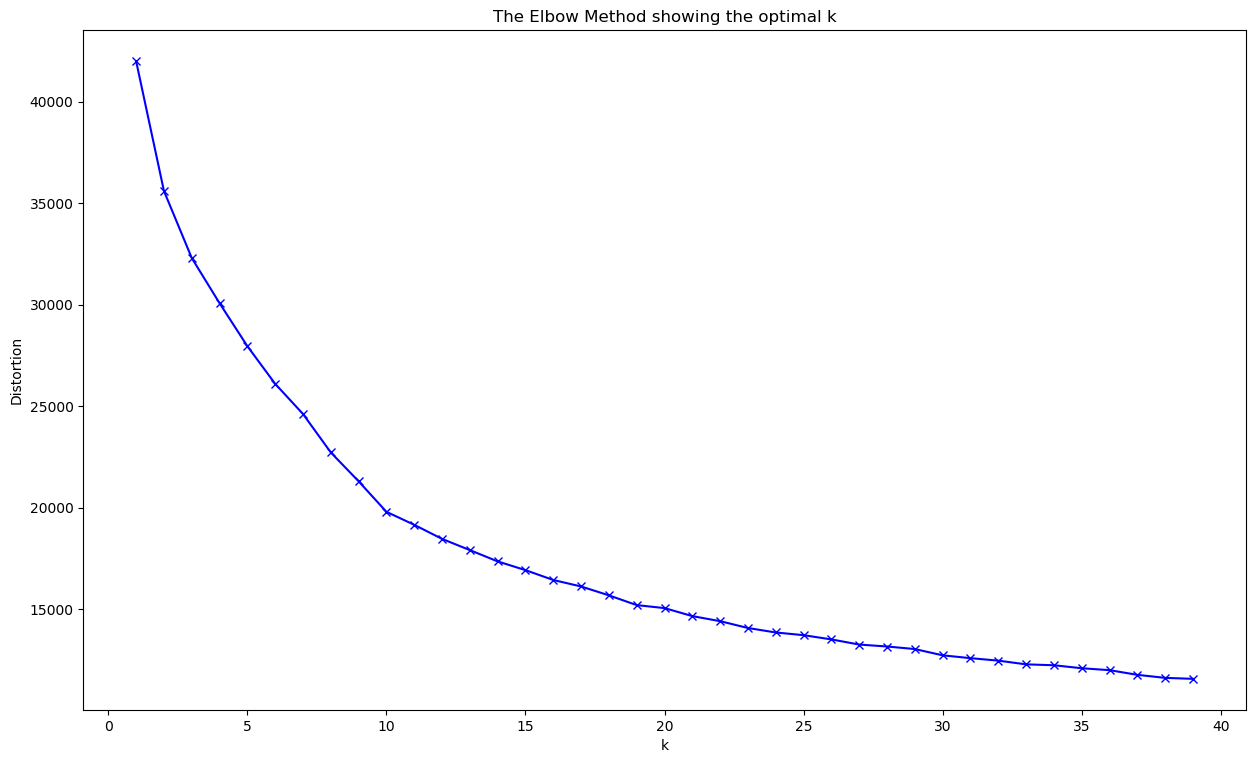

In [5]:
distortions = []
K = range(1,40)
for k in tqdm(K):
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(investor_summary_numpy)
    distortions.append(kmeanModel.inertia_)

plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [6]:
kmeans = KMeans(10)
kmeans.fit(investor_summary_numpy)
investor_summary_df["k_means_cluster"] = kmeans.predict(investor_summary_numpy)

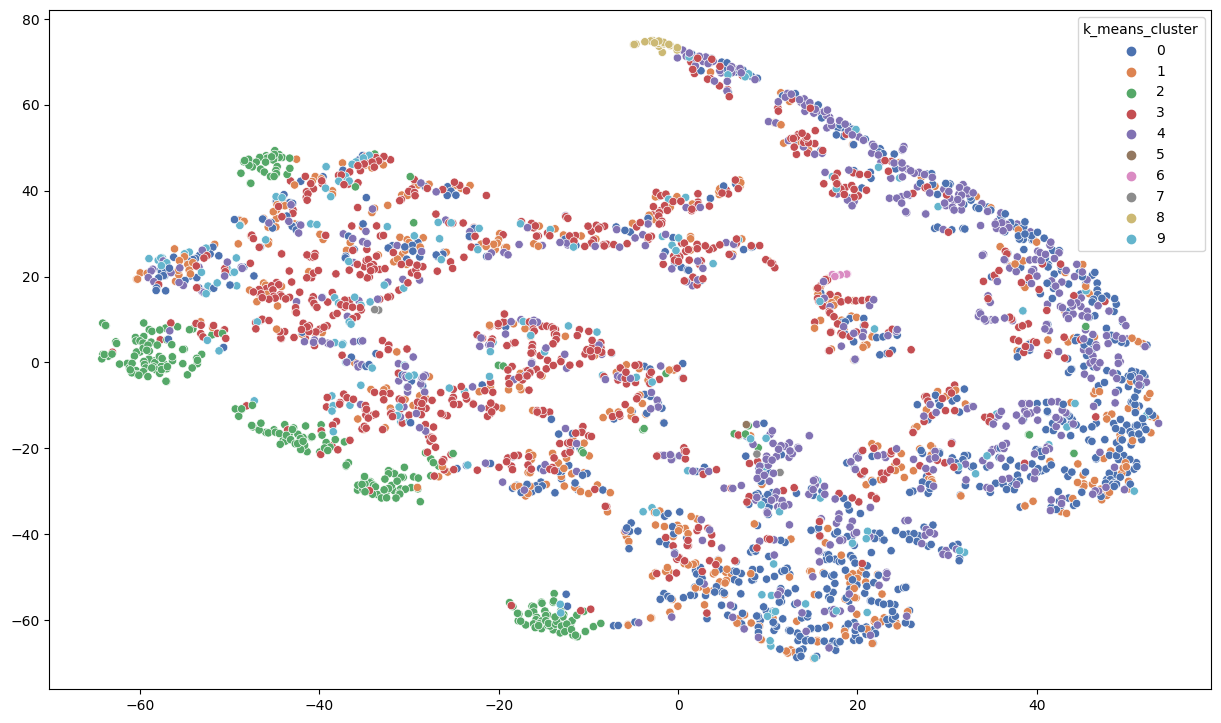

In [7]:
tsne = TSNE(n_components=2)
tsne_vals = tsne.fit_transform(investor_summary_df)

sns.scatterplot(x=tsne_vals[:,0],y=tsne_vals[:,1],hue=investor_summary_df["k_means_cluster"],palette="deep")

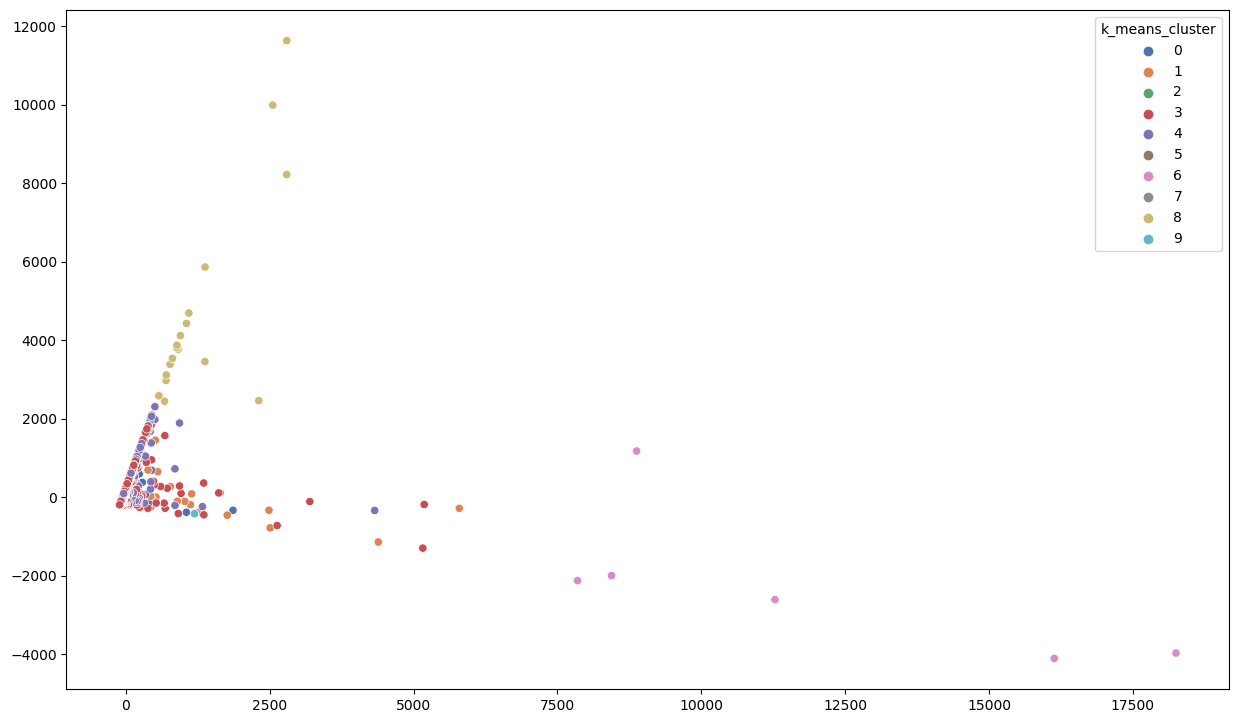

In [8]:
pca = PCA(n_components=2)
pca_vals = pca.fit_transform(investor_summary_df)

sns.scatterplot(x=pca_vals[:,0],y=pca_vals[:,1],hue=investor_summary_df["k_means_cluster"],palette="deep")

In [9]:
investor_clusters = investor_summary_df.groupby("k_means_cluster").mean()
investor_clusters["count"] = investor_summary_df.groupby("k_means_cluster")["k_means_cluster"].count()
investor_clusters

,Gain,DailyGain,ThisWeekGain,RiskScore,MaxDailyRiskScore,MaxMonthlyRiskScore,Copiers,CopyTradesPct,Trades,WinRatio,DailyDD,WeeklyDD,ActiveWeeks,WeeksSinceRegistration,count
k_means_cluster,,,,,,,,,,,,,,,
0,36.589104,-0.745676,-1.448380,4.925034,6.412316,5.311914,14.605087,3.350361,208.127182,67.535530,-4.026466,-5.777055,25.564926,95.899597,747
1,22.427397,-0.209956,-0.917527,3.566740,5.074398,3.934355,72.765862,6.664529,152.113785,65.222435,-3.015864,-4.396543,36.332603,182.520782,457
2,43.319134,-0.177882,-1.903681,4.017361,5.284722,4.350695,1.322917,83.073257,24.357639,32.342533,-4.515069,-6.878541,45.163193,268.260406,288
3,47.565445,-0.113607,-1.384318,4.104457,6.363510,5.413649,55.059887,7.353465,210.493042,66.205688,-7.420279,-10.827437,53.339832,263.805023,718
4,70.195732,-1.243667,-2.109983,5.703333,7.343333,5.871666,23.716667,2.243585,332.063324,67.027405,-7.435317,-10.162534,32.978333,114.839996,600
5,5176.029785,0.100000,-1.020000,3.000000,5.000000,3.000000,2.000000,31.578947,19.000000,47.368420,-9.390000,-9.850000,19.000000,75.000000,1
6,63.958336,-0.330000,-1.778333,3.833333,6.333333,5.000000,12066.833008,0.000000,837.166687,77.430435,-6.310000,-7.995000,57.000000,211.500000,6
7,202.429993,-0.837500,139.717499,6.250000,7.750000,5.000000,2.500000,3.571429,25.250000,58.129017,-7.080000,-8.112500,26.750000,197.500000,4
8,61.933685,-0.706842,-1.184211,4.105263,6.263158,4.947369,186.578949,0.618725,4978.947266,72.350410,-5.745790,-8.261053,51.684212,138.263153,19


In [10]:
gain_quantile = investor_summary_df['Gain'].quantile(0.5)
risk_quantile = investor_summary_df['MaxMonthlyRiskScore'].quantile(0.5)
win_quantile = investor_summary_df['WinRatio'].quantile(0.5)

best_investors = investor_summary_df[(investor_summary_df['WinRatio']>win_quantile)&
                                     (investor_summary_df['Gain']>gain_quantile)&
                                     (investor_summary_df["MaxMonthlyRiskScore"]<risk_quantile)].copy()

best_investors.sort_values("Gain",ascending=False)

,,Gain,DailyGain,ThisWeekGain,RiskScore,MaxDailyRiskScore,MaxMonthlyRiskScore,Copiers,CopyTradesPct,Trades,WinRatio,DailyDD,WeeklyDD,ActiveWeeks,WeeksSinceRegistration,k_means_cluster
CustomerId,UserName,,,,,,,,,,,,,,,
3125498,SwissInvest4Life,260.640015,-1.07,216.380005,7.0,9.0,2.0,4.0,14.285714,7.0,85.714287,-8.72,-8.72,57.0,385.0,7
14231321,Samosaking,172.850006,0.61,46.400002,3.0,5.0,4.0,174.0,0.000000,91.0,73.626373,-4.34,-6.13,35.0,38.0,1
13459955,Orfanik,116.930000,-1.55,-4.670000,4.0,5.0,4.0,14.0,2.941176,34.0,88.235291,-3.64,-6.67,44.0,47.0,1
9478562,LlLVLIU,91.660004,-1.81,-1.530000,5.0,5.0,4.0,1.0,0.000000,5.0,100.000000,-7.51,-7.51,57.0,144.0,3
14152646,Bamboo108,80.739998,5.53,2.520000,4.0,5.0,4.0,63.0,0.000000,26.0,84.615387,-6.51,-8.80,38.0,39.0,1
12363123,pino428,78.250000,0.20,-1.980000,4.0,6.0,4.0,1629.0,0.000000,723.0,68.188103,-4.06,-5.09,55.0,64.0,1
13911353,Francys1q84,72.529999,0.90,0.360000,5.0,5.0,4.0,4.0,3.236246,309.0,67.637543,-3.25,-3.25,40.0,42.0,1
10383817,Miyoshi,70.370003,0.46,-1.530000,4.0,6.0,3.0,8401.0,0.000000,3489.0,71.940384,-6.12,-6.42,57.0,109.0,6
6007622,Javilanza34,63.029999,3.99,4.690000,3.0,6.0,4.0,1.0,7.058824,85.0,69.411766,-4.63,-5.82,57.0,212.0,1


In [11]:
popular_investors = investor_summary_df[investor_summary_df["Copiers"]>investor_summary_df["Copiers"].quantile(0.99)]
popular_investors.sort_values("Gain",ascending=False)

,,Gain,DailyGain,ThisWeekGain,RiskScore,MaxDailyRiskScore,MaxMonthlyRiskScore,Copiers,CopyTradesPct,Trades,WinRatio,DailyDD,WeeklyDD,ActiveWeeks,WeeksSinceRegistration,k_means_cluster
CustomerId,UserName,,,,,,,,,,,,,,,
12780873,AntoineHaquette,173.250000,1.48,-3.31,5.0,7.0,6.0,1410.0,0.000000,312.0,67.628204,-6.87,-10.03,47.0,56.0,4
6084415,CanZhao,134.119995,-2.64,1.96,4.0,7.0,5.0,3191.0,0.000000,888.0,58.445946,-4.37,-9.88,57.0,208.0,3
9996668,jianswang,108.650002,-2.27,-6.12,5.0,7.0,6.0,4340.0,0.000000,933.0,63.987137,-6.70,-8.07,57.0,125.0,4
10501678,ReturnInvest,102.209999,-1.82,-3.19,5.0,5.0,5.0,5381.0,0.000000,198.0,83.333336,-6.10,-9.27,57.0,105.0,3
13896981,joaoguimaraes10,95.500000,0.66,-4.84,5.0,7.0,6.0,1948.0,0.000000,347.0,65.706055,-4.77,-5.47,42.0,42.0,0
5629087,ChongZheng,91.959999,6.07,3.32,5.0,6.0,5.0,1318.0,0.000000,113.0,75.221237,-9.26,-9.60,57.0,235.0,9
11782013,Prowessinvesting,89.349998,1.06,1.09,4.0,7.0,5.0,1601.0,0.000000,720.0,58.333332,-7.81,-7.81,57.0,77.0,3
5120021,hyjbrighter,80.900002,0.05,-2.04,5.0,8.0,5.0,8733.0,0.000000,304.0,72.368423,-6.59,-9.20,57.0,260.0,6
12363123,pino428,78.250000,0.20,-1.98,4.0,6.0,4.0,1629.0,0.000000,723.0,68.188103,-4.06,-5.09,55.0,64.0,1


# Explore individual stocks

In [12]:
investor_portfolio.head()

,investor_name,date,company,type,invested
0,miyoshi,2021-02-03,SQ,Buying,5.83
1,miyoshi,2021-02-03,ARKF,Buying,4.55
2,miyoshi,2021-02-03,DIS,Buying,4.22
3,miyoshi,2021-02-03,NVDA,Buying,3.65
4,miyoshi,2021-02-03,AMD,Buying,3.35


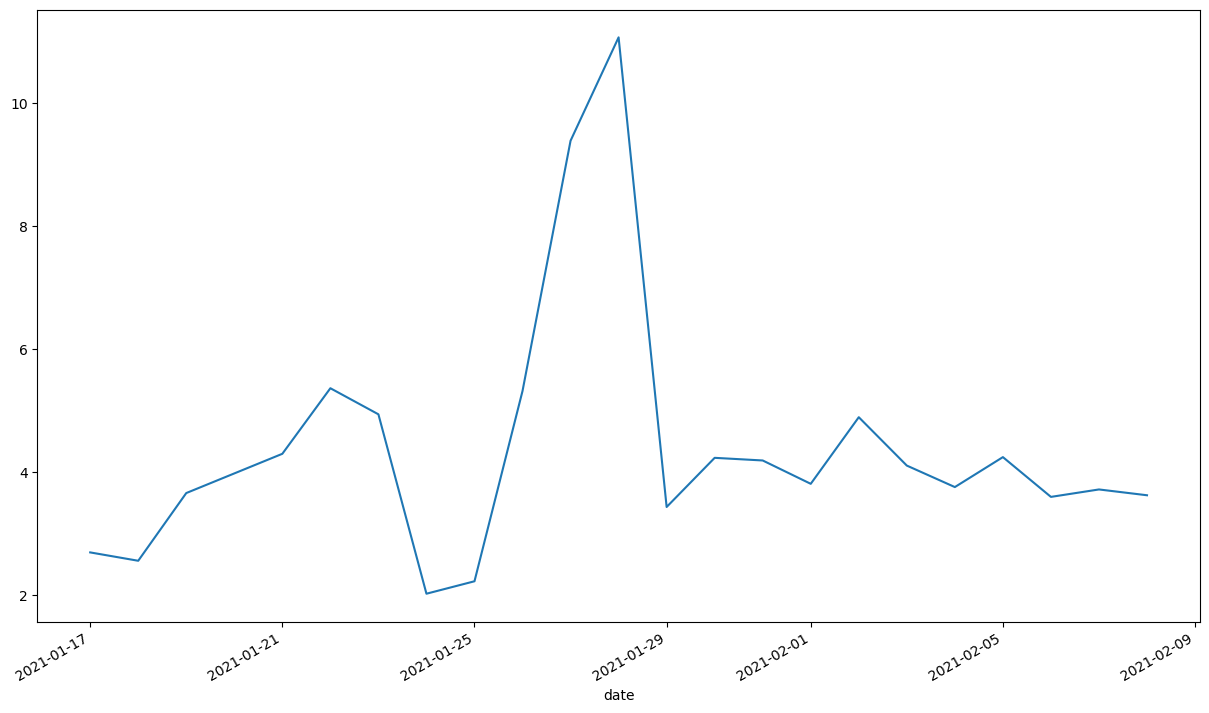

In [13]:
investor_portfolio[investor_portfolio.company=='GME'].groupby('date')['invested'].mean().plot()

In [14]:
dates = sorted(investor_portfolio.date.unique())
len(dates)

22

In [15]:
stocks = investor_portfolio.company.unique()
len(stocks)

2358

In [16]:
best_investor_list = best_investors.reset_index()['UserName'].tolist()

best_investor_stocks = investor_portfolio[investor_portfolio['investor_name'].isin(best_investor_list)]['company'].unique()
print("Stocks of best investors:", len(best_investor_stocks))

Stocks of best investors: 333


In [18]:
groupby = investor_portfolio.groupby(['company','date'])["invested"].mean()
slice_idx = pd.IndexSlice
day_threshold = 10
chg_interest = list()
for stock_name in tqdm(best_investor_stocks):
    last_interest = groupby.to_frame().loc[slice_idx[stock_name, dates[-day_threshold]:], :]
    last_interest_mean = last_interest.mean()

    historical_interest = groupby.to_frame().loc[slice_idx[stock_name, :dates[-day_threshold-1]], :]
    historical_interest_mean = historical_interest.mean()

    vals = groupby.to_frame().loc[stock_name].values.reshape(-1)
    change_in_interest = (last_interest_mean/historical_interest_mean)[0]
    chg_interest.append((stock_name,change_in_interest,historical_interest_mean[0],last_interest_mean[0]))

100%|██████████| 333/333 [00:02<00:00, 152.62it/s]


In [27]:
TOP_N_CHANGE_IN_INTEREST_AMONG_BEST_INVESTORS = 20
chg_intrst = pd.DataFrame.from_records(chg_interest,columns=['stock','change_in_interest',"history","latest"]).sort_values('change_in_interest',ascending=False)
pop_stocks = chg_intrst.head(TOP_N_CHANGE_IN_INTEREST_AMONG_BEST_INVESTORS)
pop_stocks

,stock,change_in_interest,history,latest
88,ZIL2.DE,2.233410,1.293194,2.888233
270,HEXO,1.979342,0.785536,1.554844
90,VALE,1.840475,1.669114,3.071961
129,XRP,1.718216,2.298818,3.949866
108,VBR,1.671384,2.259306,3.776167
252,CORN,1.638451,1.749722,2.866833
323,NOKIA.HE,1.523758,1.379018,2.101289
39,CNK,1.522917,1.707398,2.600226
325,EOAN.DE,1.515670,1.454529,2.204587
52,ETHEREUM,1.508158,3.393023,5.117214


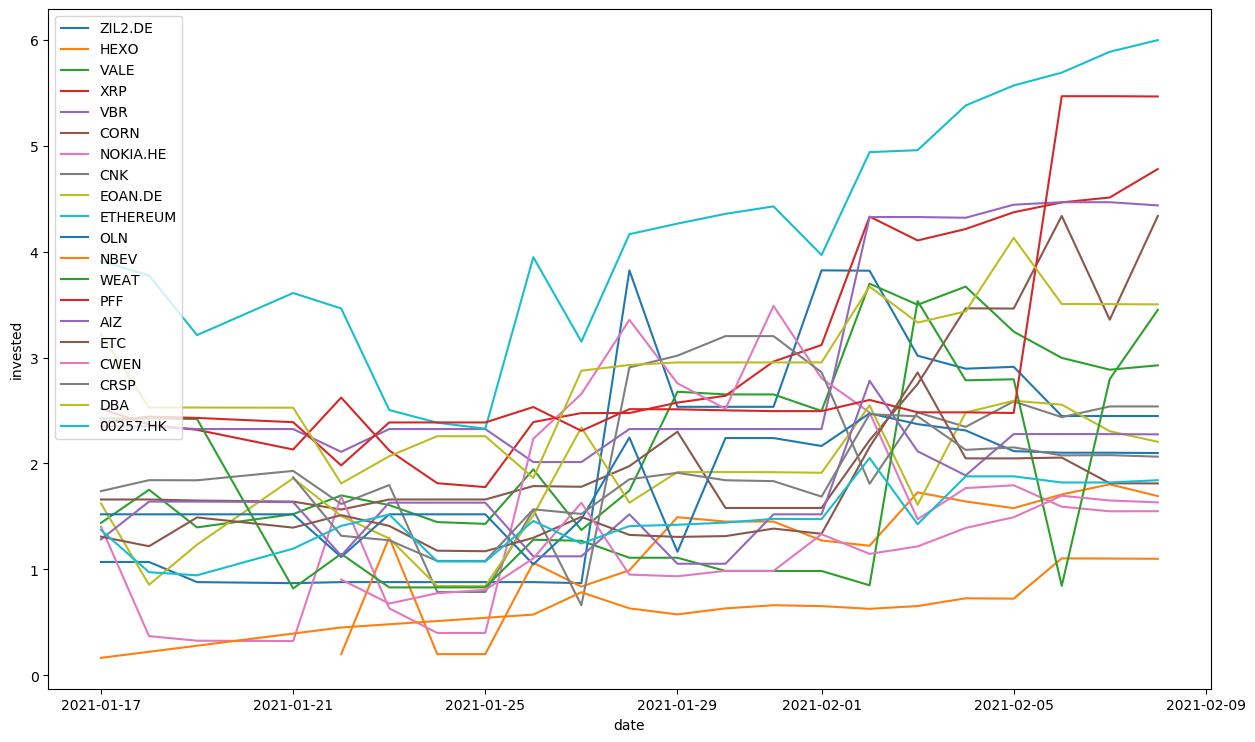

In [28]:
for int_stock in pop_stocks["stock"].values:
    vals = groupby.to_frame().loc[int_stock]
    sns.lineplot(y=vals["invested"],x=vals.index,label=int_stock)

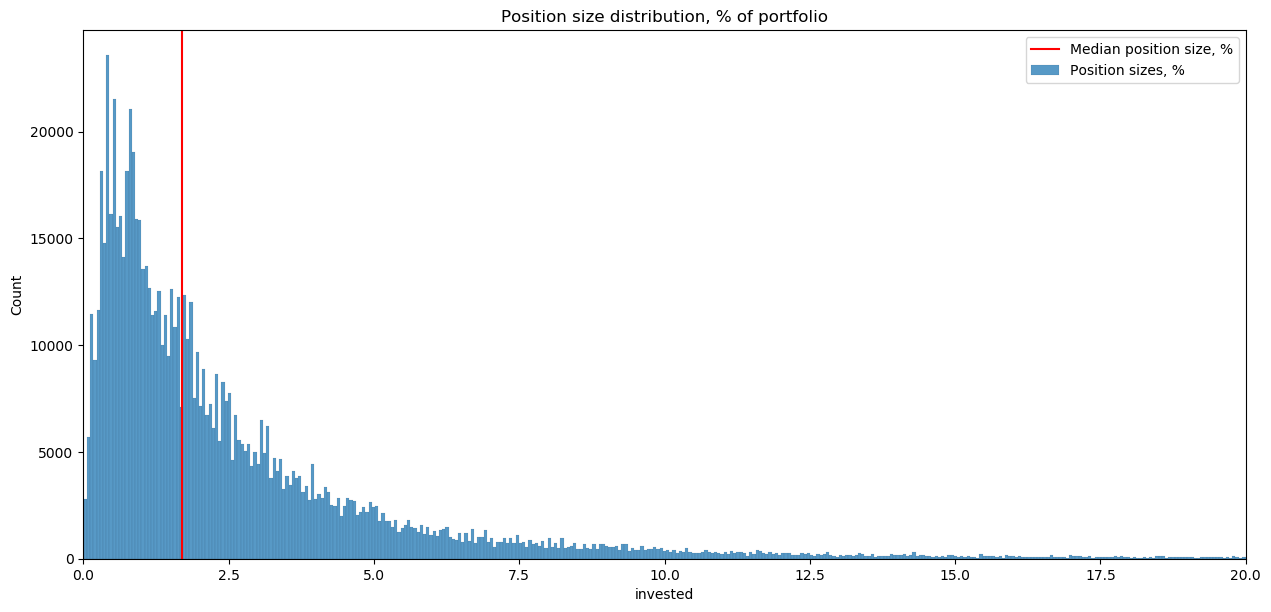

In [29]:
plt.figure(figsize=(15,7))
sns.histplot(investor_portfolio.invested, label='Position sizes, %')
plt.xlim(0,20)
plt.title("Position size distribution, % of portfolio")
plt.axvline(x=investor_portfolio.invested.median(),color='red',label='Median position size, %')
plt.legend()

In [30]:
df_marketbeat_ranks = load_marketbeat()
mb_dates = sorted(df_marketbeat_ranks.date.unique())
marketbeat_latest_date = mb_dates[-1]
df_marketbeat_ranks = df_marketbeat_ranks[df_marketbeat_ranks.date==marketbeat_latest_date].sort_values("valuation_rank",ascending=False)
df_marketbeat_ranks = df_marketbeat_ranks.set_index(["date","symbol"])
df_marketbeat_ranks.sort_values("overall_rank",ascending=False)

overall_rank  insider_rank  community_rank  valuation_rank  \
date       symbol                                                               
2021-02-08 UNH             3.03           1.7             3.4             2.5   
           ABBV            3.01           1.7             2.9             3.1   
           C               2.93           1.7             3.4             3.8   
           MCD             2.92           1.7             2.9             2.5   
           NOC             2.90           1.7             2.4             1.9   
...                         ...           ...             ...             ...   
           GOEV            0.13           0.0             0.0             0.6   
           LTRPB           0.13           0.0             0.0             0.6   
           IPOF            0.00           0.0             0.0             0.0   
           BUR             0.00           0.0             0.0             0.0   
           NYSE           -1.00           NaN             NaN             NaN   

                   dividend_rank  analyst_rank  
date       symbol                               
2021-02-08 UNH               4.2           3.4  
           ABBV              5.0           2.4  
           C                 2.5           3.3  
           MCD               4.2           3.4  
           NOC               4.2           4.4  
...                          ...           ...  
           GOEV              0.0           0.0  
           LTRPB             0.0           0.0  
           IPOF              0.0           0.0  
           BUR               0.0           0.0  
           NYSE              NaN           NaN  

[2000 rows x 6 columns]

In [31]:
df_marketbeat_targets = load_marketbeat_target()
df_marketbeat_targets = df_marketbeat_targets[df_marketbeat_targets.date==marketbeat_latest_date]
df_marketbeat_targets["delta"] = df_marketbeat_targets["ConsensusPriceTarget"]/df_marketbeat_targets["SharePrice"]
df_marketbeat_targets = df_marketbeat_targets.set_index(["date","symbol"])
df_marketbeat_targets.sort_values("delta",ascending=False)

ConsensusPriceTarget  MinPriceTarget  MaxPriceTarget  \
date       symbol                                                         
2021-02-08 ORBC                  194.25            10.0            10.0   
           SJ                     56.00            56.0            56.0   
           OPTN                   19.00            17.0            19.0   
           TXMD                    7.55             4.0             4.0   
           PRQR                   20.00            20.0            20.0   
...                                 ...             ...             ...   
           FOSL                    3.75             2.5             2.5   
           EH                     14.00            14.0            14.0   
           FUTU                   17.90            17.9            17.9   
           BLNK                    5.00             5.0             5.0   
           OAS                     1.70             3.5             3.5   

                   SharePrice Currency      delta  
date       symbol                                  
2021-02-08 ORBC      8.168750        $  23.779648  
           SJ        9.183013        $   6.098217  
           OPTN      4.218125        $   4.504371  
           TXMD      1.685625        $   4.479051  
           PRQR      5.011563        $   3.990771  
...                       ...      ...        ...  
           FOSL     14.850938        $   0.252509  
           EH       77.641875        $   0.180315  
           FUTU    106.400000        $   0.168233  
           BLNK     50.730625        $   0.098560  
           OAS      40.153750        $   0.042337  

[1691 rows x 6 columns]

In [35]:
marketbeat_df = df_marketbeat_ranks.join(df_marketbeat_targets,how="outer").sort_values("community_rank",ascending=False)
marketbeat_df.loc[slice_idx[:, pop_stocks["stock"]], :]

overall_rank  insider_rank  community_rank  valuation_rank  \
date       symbol                                                               
2021-02-08 VALE            1.69           0.0             2.2             3.1   
           CNK             1.27           1.7             2.8             0.6   
           OLN             1.50           1.7             2.2             0.6   
           NBEV             NaN           NaN             NaN             NaN   
           AIZ             2.69           1.7             2.0             3.1   
           CWEN            0.97           0.8             2.2             0.0   
           CRSP            1.33           1.7             2.7             0.0   

                   dividend_rank  analyst_rank  ConsensusPriceTarget  \
date       symbol                                                      
2021-02-08 VALE              1.7           1.5                   NaN   
           CNK               0.0           1.3                   NaN   
           OLN               0.8           2.2                   NaN   
           NBEV              NaN           NaN              4.500000   
           AIZ               4.2           2.5                   NaN   
           CWEN              0.8           1.0                   NaN   
           CRSP              0.0           2.3            141.785714   

                   MinPriceTarget  MaxPriceTarget  SharePrice Currency  \
date       symbol                                                        
2021-02-08 VALE               NaN             NaN         NaN      NaN   
           CNK                NaN             NaN         NaN      NaN   
           OLN                NaN             NaN         NaN      NaN   
           NBEV               5.0             5.0    3.185625        $   
           AIZ                NaN             NaN         NaN      NaN   
           CWEN               NaN             NaN         NaN      NaN   
           CRSP             145.0           210.0  170.548125        $   

                      delta  
date       symbol            
2021-02-08 VALE         NaN  
           CNK          NaN  
           OLN          NaN  
           NBEV    1.412596  
           AIZ          NaN  
           CWEN         NaN  
           CRSP    0.831353

In [33]:
marketwatch_df = load_marketwatch()
marketwatch_df = marketwatch_df[marketwatch_df.date==marketbeat_latest_date]
marketwatch_df = marketwatch_df.set_index(["date","symbol"])
marketwatch_df["delta"] = marketwatch_df["Median"]/marketwatch_df["Current Price"]
marketwatch_df.loc[slice_idx[:, pop_stocks["stock"]], :]

Average Recommendation Average Target Price  \
date       symbol                                               
2021-02-08 VALE                      Buy                21.14   
           CNK                Overweight                18.58   
           OLN                Overweight                28.64   
           AIZ                       Buy               163.50   
           CWEN                     Hold                31.71   
           CRSP               Overweight               146.56   

                  Number Of Ratings FY Report Date Last Quarter's Earnings  \
date       symbol                                                            
2021-02-08 VALE                  22        12/2020                    0.57   
           CNK                   12        12/2020                   -1.25   
           OLN                   15        12/2021                   -0.10   
           AIZ                    5        12/2020                    1.41   
           CWEN                   8        12/2020                    0.54   
           CRSP                  19        12/2020                   -1.32   

                  Year Ago Earnings Current Quarter's Estimate  \
date       symbol                                                
2021-02-08 VALE                0.85                       0.86   
           CNK                 1.86                      -1.46   
           OLN                -1.24                       0.29   
           AIZ                 8.64                       2.07   
           CWEN                0.36                       0.86   
           CRSP                0.01                      -1.27   

                  Current Year's Estimate Median PE on CY Estimate  \
date       symbol                                                    
2021-02-08 VALE                      1.82                      N/A   
           CNK                      -4.62                      N/A   
           OLN                       1.01                      N/A   
           AIZ                       8.92                      N/A   
           CWEN                      1.19                      N/A   
           CRSP                     -5.02                      N/A   

                  Next Fiscal Year Estimate Median PE on Next FY Estimate  \
date       symbol                                                           
2021-02-08 VALE                        3.45                           N/A   
           CNK                        -2.25                           N/A   
           OLN                         1.52                           N/A   
           AIZ                        10.71                           N/A   
           CWEN                        0.97                           N/A   
           CRSP                       -5.31                           N/A   

                     High  Median    Low  Average  Current Price     delta  
date       symbol                                                           
2021-02-08 VALE     27.24    20.0   16.6    21.14          17.26  1.158749  
           CNK      28.00    16.5   13.0    18.58          19.82  0.832492  
           OLN      35.00    27.0   25.0    28.64          27.26  0.990462  
           AIZ     172.00   166.0  150.0   163.50         134.36  1.235487  
           CWEN     38.00    32.0   22.0    31.71          31.90  1.003135  
           CRSP    210.00   160.0   45.0   146.56         168.81  0.947811